## interesting links

In [37]:
#https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial/notebook
#https://www.kaggle.com/code/tarunpaparaju/m5-competition-eda-models/notebook
#https://analyticsindiamag.com/how-to-do-multivariate-time-series-forecasting-using-lstm/
#https://www.relataly.com/feature-engineering-for-multivariate-time-series-models-with-python/1813/


In [1]:
import os
import pandas as pd
import glob
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import plotly.express as px
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
import lightgbm as lgb
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error,r2_score
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
pd.options.display.max_colwidth = 1000


## Data pipeline

In [2]:
exogenous_features = ['wind_spd_ygn_1', 'dew_point_ygn_1', 'temp_ygn_1',
       'wind_spd_mj_1', 'dew_point_mj_1', 'temp_mj_1', 'wind_spd_ria_1',
       'dew_point_ria_1', 'temp_ria_1', 'dew_point_bl_1', 'actual_temp_1',
       'wind_chill_ygn_1','wind_dir_ygn_1_N', 'wind_dir_ygn_1_NE', 'wind_dir_ygn_1_NNE',
       'wind_dir_mj_1_N', 'wind_dir_mj_1_NE', 'wind_dir_mj_1_NNE',
       'wind_dir_ria_1_N', 'wind_dir_ria_1_NE', 'wind_dir_ria_1_NNE', 'month',
       'week', 'day', 'day_of_week','hmdx_ygn_1']


In [3]:
def data_load_pipeline(data_file_location,data_type,exogenous_features=exogenous_features):
    data = pd.read_csv(data_file_location)
    data.Date = pd.to_datetime(data.Date)
    data = data.set_index('Date',drop=False)
    data = data.sort_index()
    train,test = train_test_split(data,test_size=0.2,shuffle=False)
    
    
    y_train = train.loc[:, train.columns == 'actual_temp']
    X_train = train.loc[:, train.columns != 'actual_temp']
    y_test = test.loc[:, test.columns == 'actual_temp']
    X_test = test.loc[:, test.columns != 'actual_temp']
    
#     X_test = X_test.loc[:, X_test.columns != 'solar_rad_1']
#     X_train = X_train.loc[:, X_train.columns != 'solar_rad_1']

    #LGBM
    params = {"objective": "regression"}
    dtrain = lgb.Dataset(train[exogenous_features], label=train.actual_temp.values)
    dtest = lgb.Dataset(test[exogenous_features])
    model_lgb = lgb.train(params, train_set=dtrain)
    forecast = model_lgb.predict(test[exogenous_features])
    test["Forecast_LightGBM"] = forecast

    plt.rcParams["figure.figsize"] = [16,9]
    lgb.plot_importance(model_lgb, max_num_features = 30, importance_type = 'split')
    plt.show()
    
    print(data_type)
    print("RMSE of LightGBM:", np.sqrt(mean_squared_error(test.actual_temp, test.Forecast_LightGBM)))
    print("MAE of LightGBM:", mean_absolute_error(test.actual_temp, test.Forecast_LightGBM))
    print("R2 of LightGBM:", r2_score(test.actual_temp, test.Forecast_LightGBM))
    return train, test
    


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 14388, number of used features: 26
[LightGBM] [Info] Start training from score 12.835863


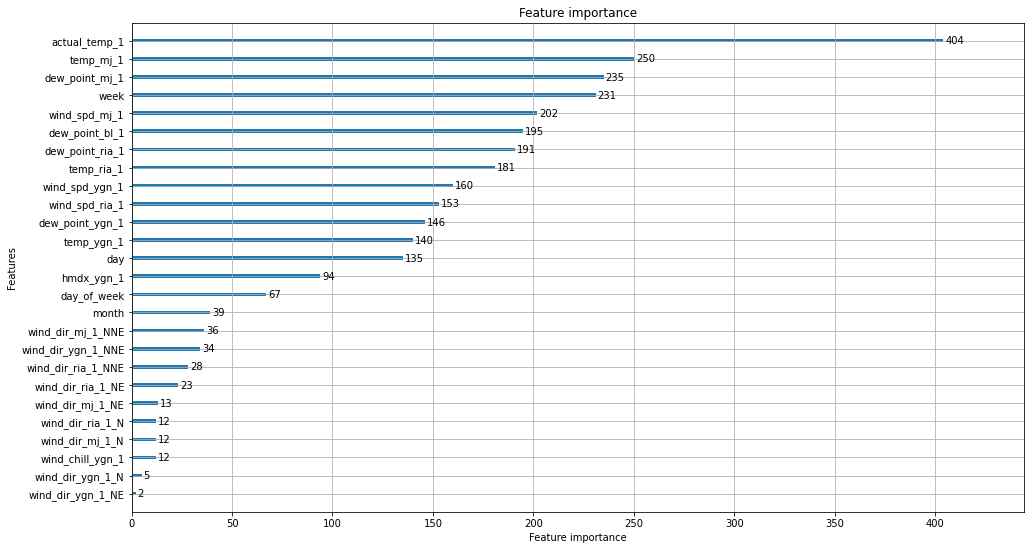

summer+day
RMSE of LightGBM: 1.6717748165602109
MAE of LightGBM: 1.2481377908456763
R2 of LightGBM: 0.9799055343866987


In [4]:
train,test = data_load_pipeline(r"../data/processed_data/summer_day_df_reg.csv",data_type="summer+day")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 7337, number of used features: 26
[LightGBM] [Info] Start training from score 6.143574


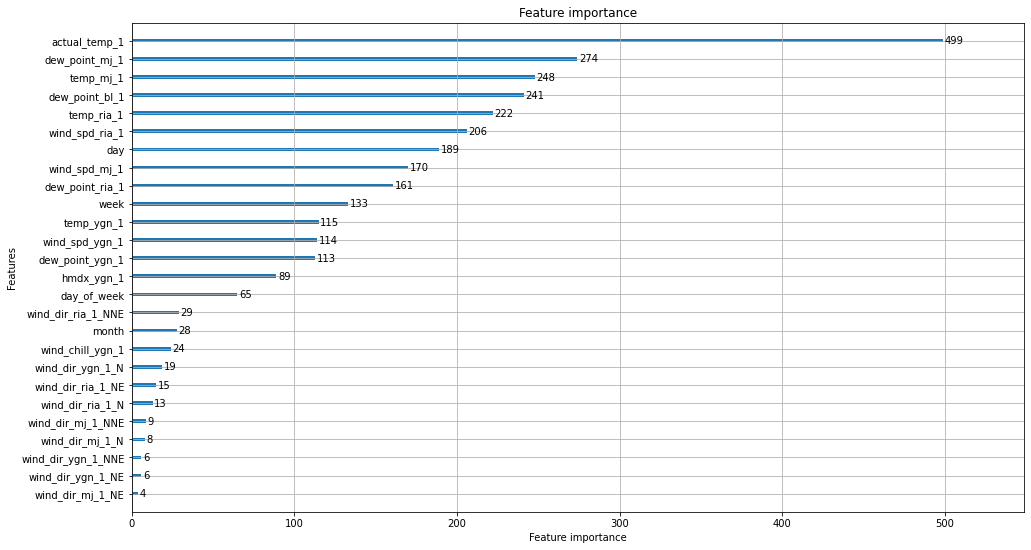

summer+night
RMSE of LightGBM: 1.1985122108057886
MAE of LightGBM: 0.8190534825562196
R2 of LightGBM: 0.9842511922636628


In [5]:
train,test = data_load_pipeline(r"../data/processed_data/summer_night_df_reg.csv",data_type="summer+night")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 7441, number of used features: 26
[LightGBM] [Info] Start training from score -0.847117


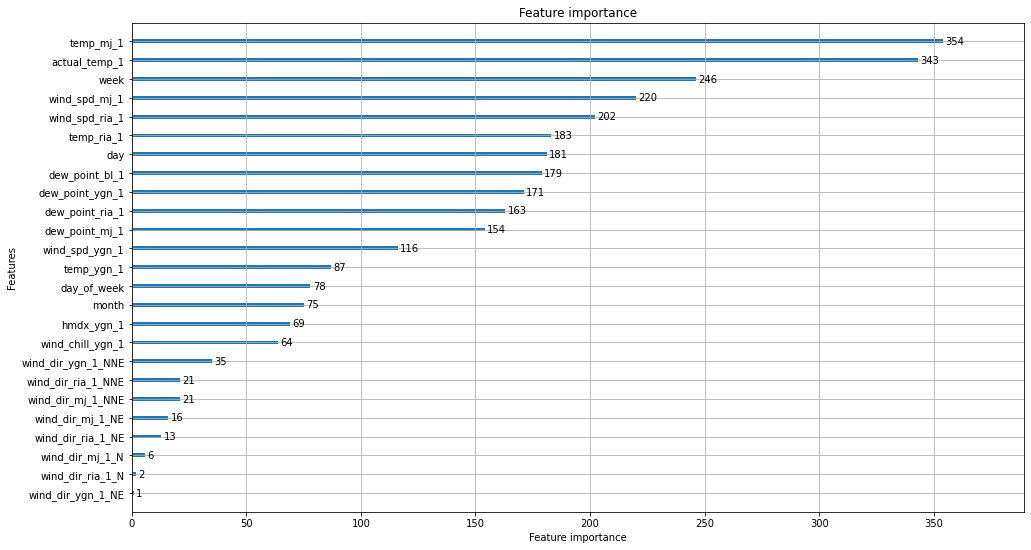

winter+day
RMSE of LightGBM: 1.2274673062496235
MAE of LightGBM: 0.8853177399135481
R2 of LightGBM: 0.9922643439267441


In [6]:
train,test = data_load_pipeline(r"../data/processed_data/winter_day_df_reg.csv",data_type="winter+day")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 12374, number of used features: 26
[LightGBM] [Info] Start training from score -4.227865


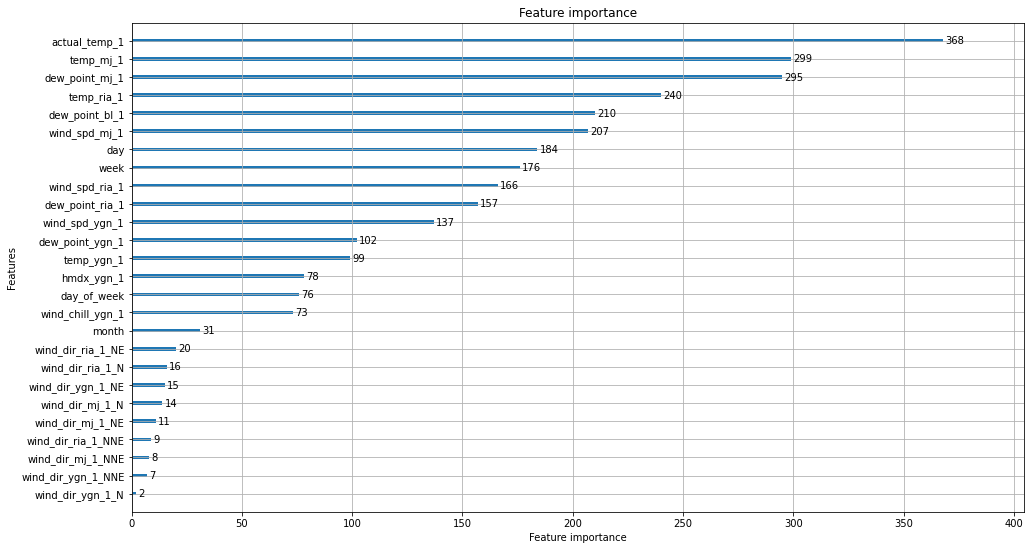

winter+night
RMSE of LightGBM: 1.3781100779876228
MAE of LightGBM: 0.9286416696685331
R2 of LightGBM: 0.9841618772613532


In [7]:
train,test = data_load_pipeline(r"../data/processed_data/winter_night_df_reg.csv",data_type="winter+night")

In [64]:
data = pd.read_csv("../data/processed_data/total_data.csv")
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')

# data_no_dir = pd.read_csv("total_data_no_wind_dir.csv")
# data_no_dir.Date = pd.to_datetime(data_no_dir.Date)
# data_no_dir = data_no_dir.set_index('Date')

# data_no_dir_label = pd.read_csv("total_data_no_wind_dir_label.csv")
# data_no_dir_label.Date = pd.to_datetime(data_no_dir_label.Date)
# data_no_dir_label = data_no_dir_label.set_index('Date')


In [65]:
train,test = train_test_split(data,test_size=0.2,shuffle=False)

y_train = train.loc[:, train.columns == 'actual_temp']
X_train = train.loc[:, train.columns != 'actual_temp']

y_test = test.loc[:, test.columns == 'actual_temp']
X_test = test.loc[:, test.columns != 'actual_temp']

In [67]:
X_train

,wind_spd_tia_1,dew_point_tia_1,temp_tia_1,wind_spd_tcc_1,dew_point_tcc_1,temp_tcc_1,wind_spd_b_1,dew_point_b_1,temp_b_1,dew_point_tc_1,...,wind_dir_tcc_1_N,wind_dir_tcc_1_NE,wind_dir_tcc_1_NNE,wind_dir_b_1_N,wind_dir_b_1_NE,wind_dir_b_1_NNE,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,20.0,-5.1,-0.3,37.0,-3.7,1.1,9.0,-15.1,-9.5,-4.3,...,0,0,1,0,0,1,1,53,1,4
2016-01-01 02:00:00,25.0,-5.5,-0.3,37.0,-3.8,0.9,9.0,-15.1,-9.5,-4.6,...,0,0,1,0,0,1,1,53,1,4
2016-01-01 03:00:00,26.0,-4.7,-0.4,37.0,-3.0,0.8,9.0,-15.1,-9.5,-4.0,...,0,0,1,0,0,1,1,53,1,4
2016-01-01 04:00:00,30.0,-4.7,-0.4,41.0,-2.9,0.8,9.0,-15.1,-9.5,-3.1,...,0,0,1,0,0,1,1,53,1,4
2016-01-01 05:00:00,31.0,-5.6,-0.4,34.0,-2.9,0.7,9.0,-15.1,-9.5,-3.9,...,0,0,1,0,0,1,1,53,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13 00:00:00,13.0,-2.9,-1.4,17.0,-2.4,-0.5,13.0,-3.2,-1.2,-3.0,...,0,0,1,0,0,1,1,2,13,2
2021-01-13 01:00:00,12.0,-3.0,-1.4,17.0,-2.3,-0.4,13.0,-3.3,-1.4,-3.0,...,0,0,1,0,0,1,1,2,13,2
2021-01-13 02:00:00,11.0,-2.9,-1.4,18.0,-2.3,-0.5,10.0,-3.1,-1.3,-3.0,...,0,0,1,0,0,1,1,2,13,2


In [66]:
X_test

,wind_spd_tia_1,dew_point_tia_1,temp_tia_1,wind_spd_tcc_1,dew_point_tcc_1,temp_tcc_1,wind_spd_b_1,dew_point_b_1,temp_b_1,dew_point_tc_1,...,wind_dir_tcc_1_N,wind_dir_tcc_1_NE,wind_dir_tcc_1_NNE,wind_dir_b_1_N,wind_dir_b_1_NE,wind_dir_b_1_NNE,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-13 05:00:00,12.0,-2.8,-0.9,18.0,-2.3,0.1,9.0,-3.0,-1.3,-2.7,...,0,0,1,0,0,1,1,2,13,2
2021-01-13 06:00:00,13.0,-2.8,-0.7,21.0,-1.9,0.2,12.0,-3.2,-1.0,-2.7,...,0,0,1,0,0,1,1,2,13,2
2021-01-13 07:00:00,10.0,-2.2,-0.7,21.0,-0.8,0.5,14.0,-3.1,-0.8,-1.6,...,0,0,1,0,0,1,1,2,13,2
2021-01-13 08:00:00,9.0,-1.6,-0.6,21.0,-0.1,0.9,14.0,-2.4,-0.9,-1.0,...,0,0,1,0,0,1,1,2,13,2
2021-01-13 09:00:00,13.0,-1.4,-0.1,24.0,-0.9,1.2,13.0,-1.7,-0.6,-1.3,...,0,0,1,0,0,1,1,2,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 19:00:00,9.0,-8.3,11.2,5.0,-7.3,10.7,16.0,-7.4,12.0,-7.0,...,0,0,1,0,0,1,4,17,30,5
2022-04-30 20:00:00,4.0,-9.8,11.1,5.0,-5.2,9.8,8.0,-7.2,11.2,-8.4,...,1,0,0,0,0,1,4,17,30,5
2022-04-30 21:00:00,8.0,-9.2,9.9,21.0,-2.4,8.9,7.0,-8.3,10.7,-8.5,...,1,0,0,0,0,1,4,17,30,5


In [33]:
# train = pd.read_csv("train.csv")
# train.Date = pd.to_datetime(train.Date)
# train = train.set_index("Date",drop=False)
# train = train.sort_index()

# test = pd.read_csv("test.csv")
# test.Date = pd.to_datetime(test.Date)
# test = test.set_index("Date",drop=False)
# test = test.sort_index()


In [32]:
X_train.shape[1]

32

In [35]:
X_test.shape

(10573, 32)

## LSTM

In [57]:
def get_model(params, input_shape):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
    model.add(Dropout(rate=params["dropout"]))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))
    model.add(LSTM(units=params["lstm_units"], return_sequences=False))
    model.add(Dropout(rate=params["dropout"]))
    model.add(Dense(1))
    model.compile(loss=params["loss"],
        optimizer=params["optimizer"],
        metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [58]:
params = {
"loss": "mean_squared_error",
"optimizer": "adam",
"dropout": 0.2,
"lstm_units": 90,
"epochs": 30,
"batch_size": 128,
"es_patience" : 10
}

model = get_model(params=params, input_shape=X_train.shape[1])

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 90)             44280     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 90)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 90)             65160     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 90)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 90)             65160     
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 90)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 90)               

In [60]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min', 
patience=params["es_patience"])

In [61]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [62]:
model.fit(
X_train,
y_train,
validation_data=(X_test, y_test),
epochs=params["epochs"],
batch_size=params["batch_size"],
verbose=1,
callbacks=[es_callback]
)

Epoch 1/30


ValueError: in user code:

    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\keras\engine\input_spec.py:218 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)


## ARIMA
- took 1 hour to train

In [29]:
exogenous_features = ['wind_spd_ygn_1', 'dew_point_ygn_1', 'temp_ygn_1',
       'wind_spd_mj_1', 'dew_point_mj_1', 'temp_mj_1', 'wind_spd_ria_1',
       'dew_point_ria_1', 'temp_ria_1', 'dew_point_bl_1', 'actual_temp_1',
       'wind_chill_ygn_1', 'weather_label_ygn_1_Clear',
       'weather_label_ygn_1_Cloudy', 'weather_label_ygn_1_Fog',
       'weather_label_ygn_1_Rain', 'weather_label_ygn_1_Snow',
       'wind_dir_ygn_1_N', 'wind_dir_ygn_1_NE', 'wind_dir_ygn_1_NNE',
       'wind_dir_mj_1_N', 'wind_dir_mj_1_NE', 'wind_dir_mj_1_NNE',
       'wind_dir_ria_1_N', 'wind_dir_ria_1_NE', 'wind_dir_ria_1_NNE', 'month',
       'week', 'day', 'day_of_week']


In [11]:
model = auto_arima(train.actual_temp, exogenous=train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train.actual_temp, exogenous=train[exogenous_features])

forecast = model.predict(n_periods=len(test), exogenous=test[exogenous_features])
test["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=90806.071, Time=116.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92293.407, Time=27.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92200.734, Time=93.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=92174.490, Time=112.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92291.408, Time=55.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=90843.684, Time=116.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=90867.609, Time=112.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=90939.971, Time=122.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=91022.040, Time=137.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=90854.348, Time=108.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=91978.095, Time=135.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=92006.635, Time=118.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=90653.259, Time=143.27 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=90532.676, Time=151.4

c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



## Prophet

In [25]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

In [26]:
model_fbp.fit(train[['Date','actual_temp']+exogenous_features].rename(columns={"Date":"ds","actual_temp":"y"}))

Initial log joint probability = -3592.13
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        142404   0.000809671       30362.7           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        142722   0.000253424       19471.8      0.4566           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        142730   0.000142437       3676.35           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        142732   6.38252e-05       1362.95           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        142732   0.000248158       2108.08           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

   142735   8.60103e-05       2614.31      0.3699      0.3699      663   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        142737   4.58495e-05        864.55           1           1      772   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799        142737   0.000158006       1183.53           1           1      886   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        142737   8.79734e-06       1164.91      0.6006      0.6006      992   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999        142738   0.000167534       880.975      0.9966      0.9966     1100   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        142738   0.000449244       1610.29           1           1     1210   
    Iter      log prob        |

In [27]:
forecast = model_fbp.predict(test[["Date","actual_temp"]+exogenous_features].rename(columns={"Date":"ds"}))
test["Forecast_Prophet"] = forecast.yhat.values

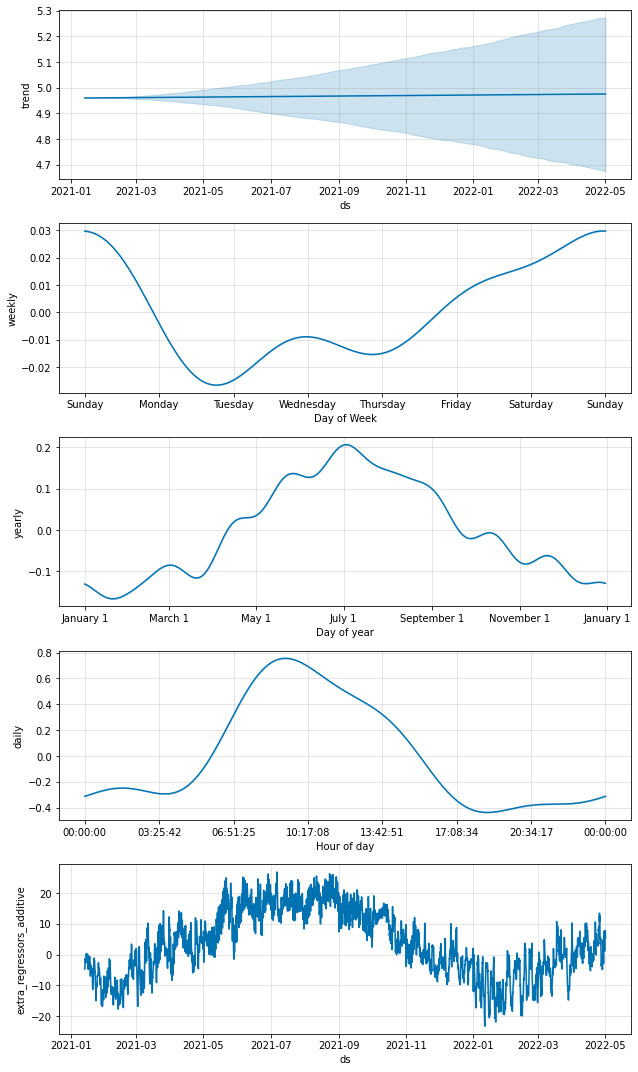

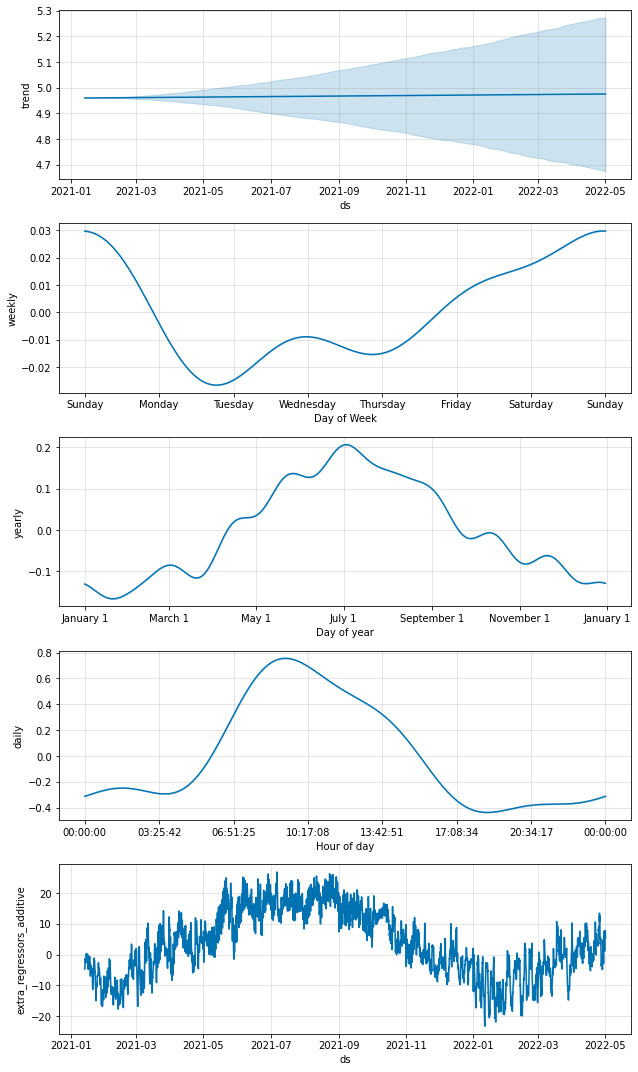

In [29]:
model_fbp.plot_components(forecast)

<AxesSubplot:xlabel='Date'>

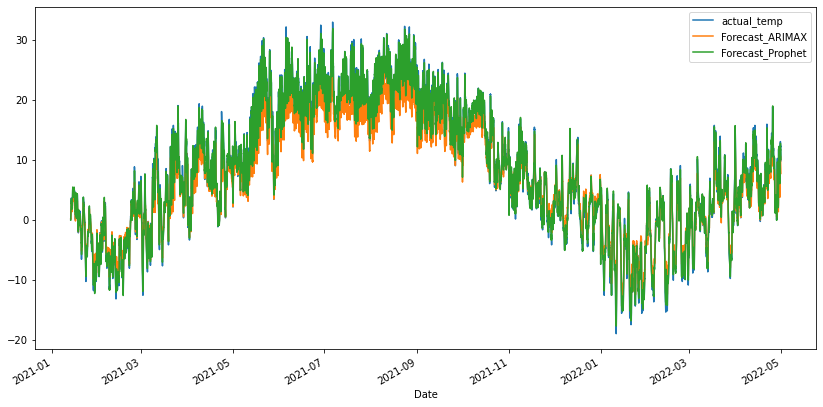

In [30]:
test[["actual_temp","Forecast_ARIMAX","Forecast_Prophet"]].plot(figsize=(14,7))

## LightGBM

In [34]:
params = {"objective": "regression"}

dtrain = lgb.Dataset(train[exogenous_features], label=train.actual_temp.values)
dtest = lgb.Dataset(test[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(test[exogenous_features])
test["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 42288, number of used features: 30
[LightGBM] [Info] Start training from score 10.316399


<AxesSubplot:xlabel='Date'>

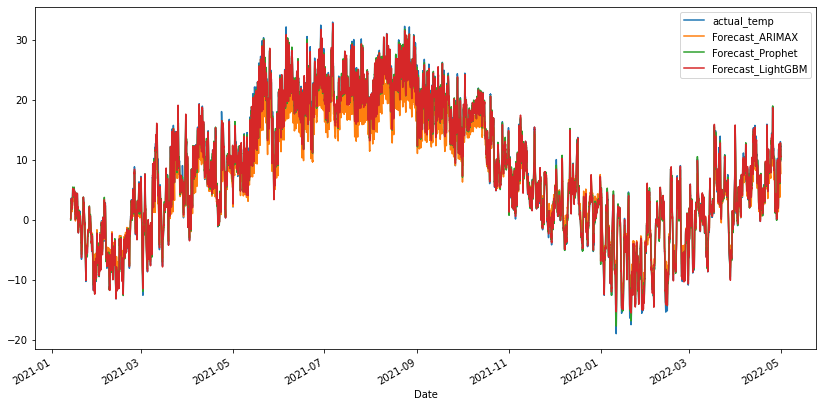

In [35]:
test[["actual_temp", "Forecast_ARIMAX", "Forecast_Prophet", "Forecast_LightGBM"]].plot(figsize=(14, 7))

## Error metrics

In [13]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [48]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(test.actual_temp, test.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(test.actual_temp, test.Forecast_Prophet)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(test.actual_temp, test.Forecast_LightGBM)))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(test.actual_temp, test.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(test.actual_temp, test.Forecast_Prophet))
print("MAE of LightGBM:", mean_absolute_error(test.actual_temp, test.Forecast_LightGBM))

print("\nMAPE of Auto ARIMAX:", mean_absolute_percentage_error(test.actual_temp, test.Forecast_ARIMAX))
print("MAPE of Prophet:", mean_absolute_percentage_error(test.actual_temp, test.Forecast_Prophet))
print("MAPE of LightGBM:", mean_absolute_percentage_error(test.actual_temp, test.Forecast_LightGBM))

print("\nsMAPE of Auto ARIMAX:", smape(test.actual_temp, test.Forecast_ARIMAX))
print("sMAPE of Prophet:", smape(test.actual_temp, test.Forecast_Prophet))
print("sMAPE of LightGBM:", smape(test.actual_temp, test.Forecast_LightGBM))

print("\nR2 of Auto ARIMAX:", r2_score(test.actual_temp, test.Forecast_ARIMAX))
print("R2 of Prophet:", r2_score(test.actual_temp, test.Forecast_Prophet))
print("R2 of LightGBM:", r2_score(test.actual_temp, test.Forecast_LightGBM))

RMSE of Auto ARIMAX: 2.2465725197737565
RMSE of Prophet: 0.7022345031468229
RMSE of LightGBM: 0.8081883144061222

MAE of Auto ARIMAX: 1.7742792991644516
MAE of Prophet: 0.4985769353270404
MAE of LightGBM: 0.5753165809303864

MAPE of Auto ARIMAX: 5243576079530.663
MAPE of Prophet: 4855521403665.371
MAPE of LightGBM: 4928808595169.991

sMAPE of Auto ARIMAX: 25.89435268583105
sMAPE of Prophet: 12.305215571793346
sMAPE of LightGBM: 12.859472129098293

R2 of Auto ARIMAX: 0.9549324808296925
R2 of Prophet: 0.995596610569661
R2 of LightGBM: 0.994167591946191


## output forecast data

In [43]:
test.to_csv("test.csv")
train.to_csv("train.csv")